Descriptive analysis

In [3]:
from google.colab import files

# Upload files
uploaded = files.upload()

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.multioutput import MultiOutputRegressor
from lightgbm import LGBMRegressor
from tensorflow.keras import models, layers
from tensorflow.keras import callbacks



# Read the dataset
df = pd.read_csv('Dataset-PT.csv', skiprows=1)


In [5]:
# Basic structure
print(df.info())
print(df.head())

# Summary statistics for numeric features
print(df.describe())

# Missing values
print(df.isna().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545103 entries, 0 to 545102
Data columns (total 31 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   calendar_date                      545103 non-null  int64  
 1   route_id                           545103 non-null  int64  
 2   bus_id                             545103 non-null  int64  
 3   stop_sequence                      545103 non-null  int64  
 4   arrival_delay                      545103 non-null  int64  
 5   dwell_time                         545103 non-null  int64  
 6   travel_time_for_previous_section   545103 non-null  int64  
 7   scheduled_travel_time              545103 non-null  int64  
 8   upstream_stop_delay                545103 non-null  int64  
 9   origin_delay                       545103 non-null  int64  
 10  previous_bus_delay                 545103 non-null  int64  
 11  previous_trip_travel_time          5451

In [6]:
print(df.columns.tolist())


['calendar_date', 'route_id', 'bus_id', 'stop_sequence', 'arrival_delay', 'dwell_time', 'travel_time_for_previous_section', 'scheduled_travel_time', 'upstream_stop_delay', 'origin_delay', 'previous_bus_delay', 'previous_trip_travel_time', 'traffic_condition', 'recurrent_delay', 'weather', 'temperature', 'day_of_week', 'time_of_day', 'factor(weather)Light_Rain', 'factor(weather)Light_Snow', 'factor(weather)Normal', 'factor(weather)Rain', 'factor(weather)Snow', 'factor(temperature)Cold', 'factor(temperature)Extra_cold', 'factor(temperature)Normal', 'factor(day_of_week)weekday', 'factor(day_of_week)weekend', 'factor(time_of_day)Afternoon_peak', 'factor(time_of_day)Morning_peak', 'factor(time_of_day)Off-peak']


In [7]:
cat_cols = ['day_of_week', 'time_of_day', 'weather', 'temperature']
for col in cat_cols:
    print(f"\n{col} distribution:")
    print(df[col].value_counts(normalize=True)*100)



day_of_week distribution:
day_of_week
weekday    76.71009
weekend    23.28991
Name: proportion, dtype: float64

time_of_day distribution:
time_of_day
OP    62.643023
AP    20.867799
MP    16.489177
Name: proportion, dtype: float64

weather distribution:
weather
Normal        94.472237
Light Rain     2.446877
Light Snow     1.783149
Snow           0.678587
Rain           0.619149
Name: proportion, dtype: float64

temperature distribution:
temperature
Normal        86.933479
Cold          11.273466
Extra cold     1.793056
Name: proportion, dtype: float64


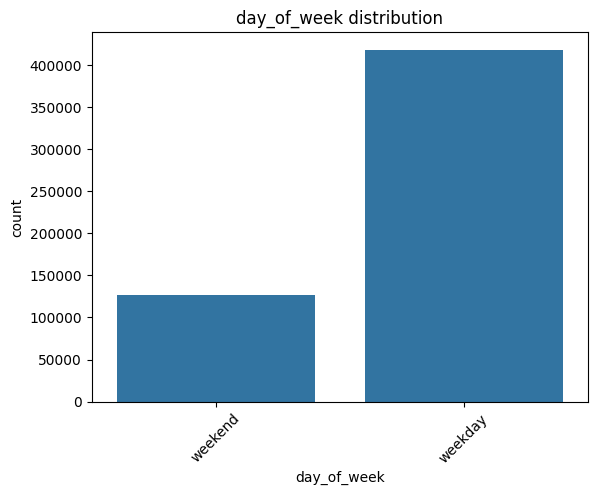

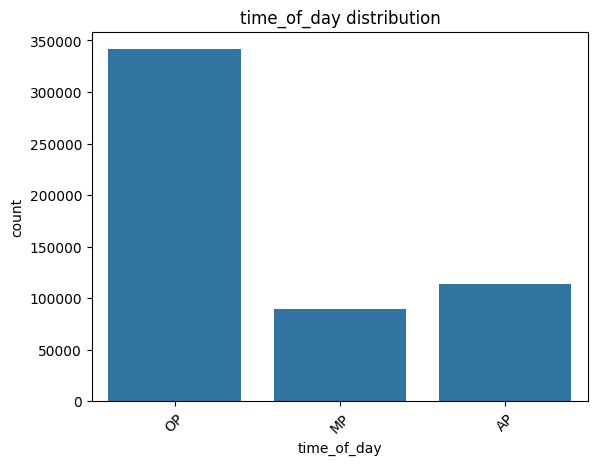

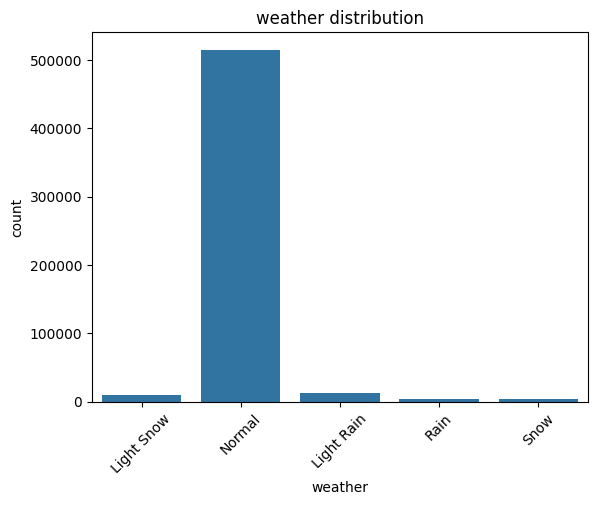

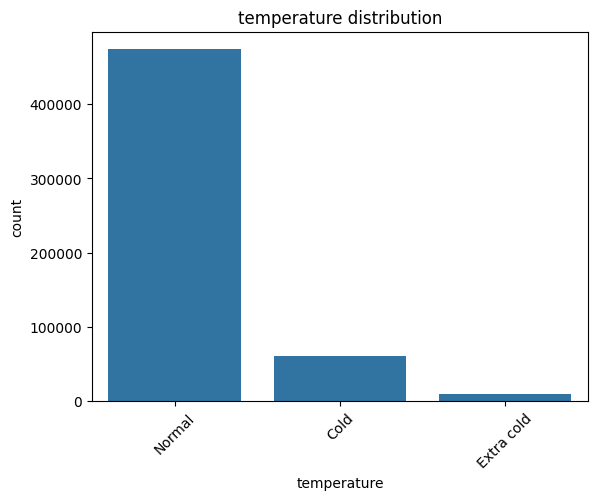

In [8]:
for col in cat_cols:
    sns.countplot(data=df, x=col)
    plt.title(f"{col} distribution")
    plt.xticks(rotation=45)
    plt.show()


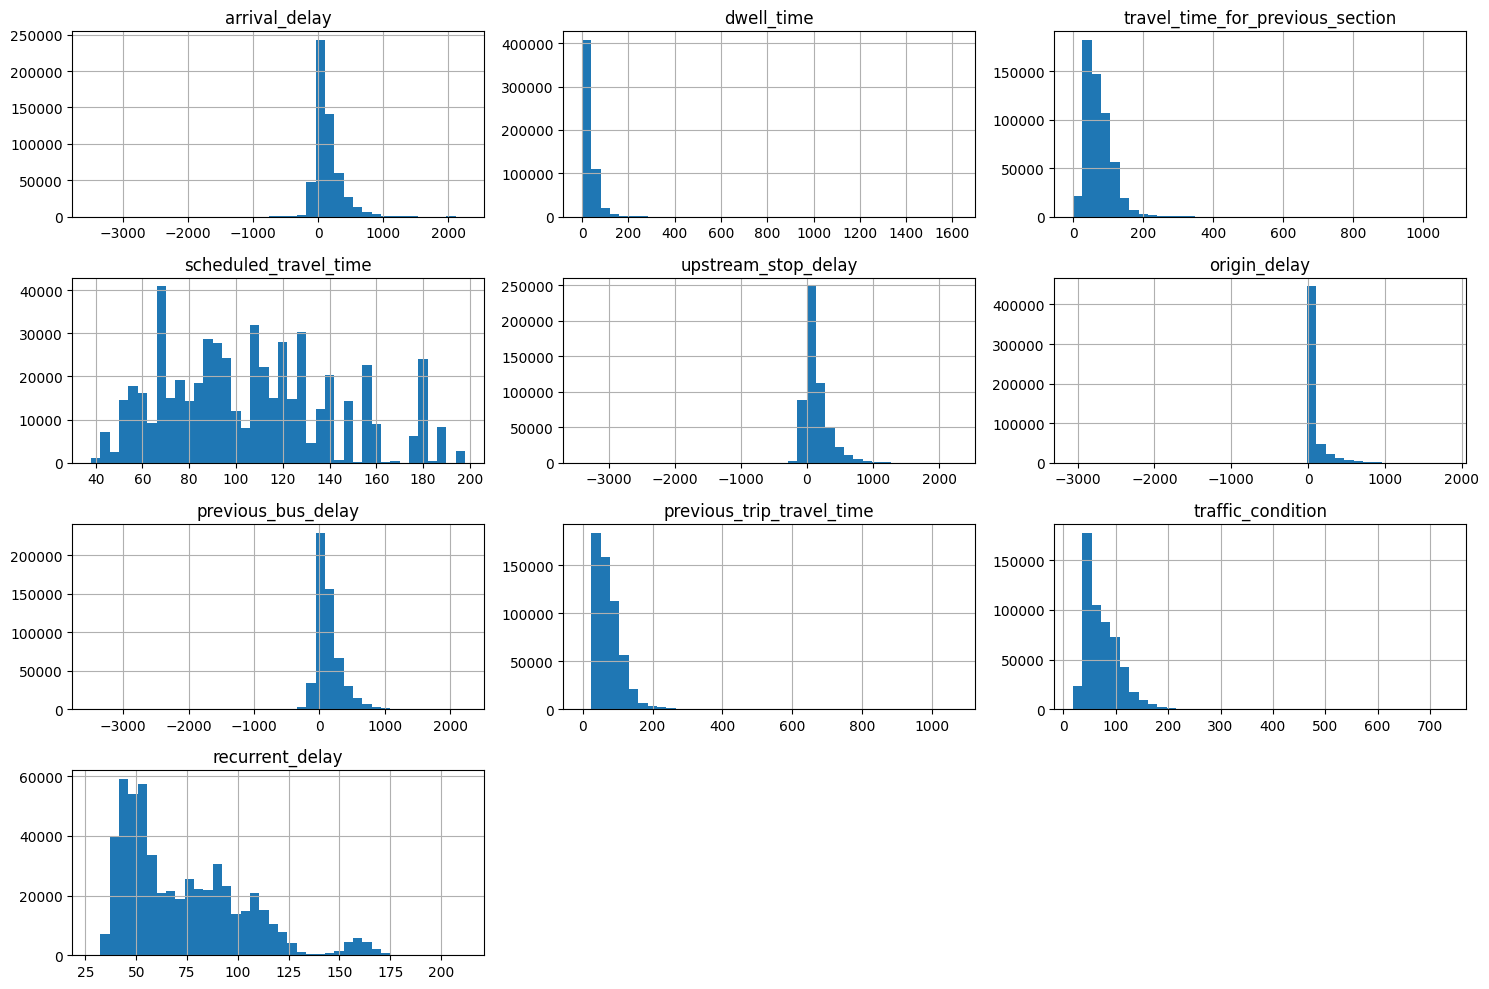

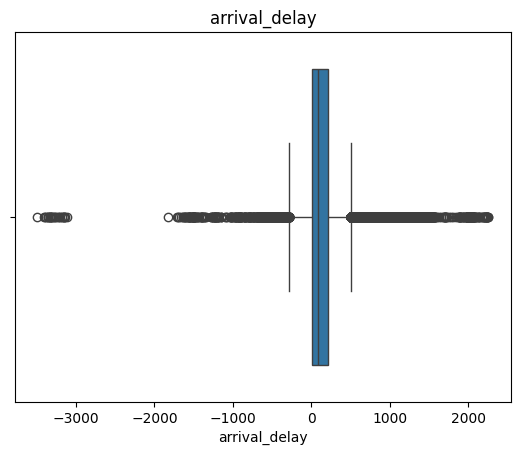

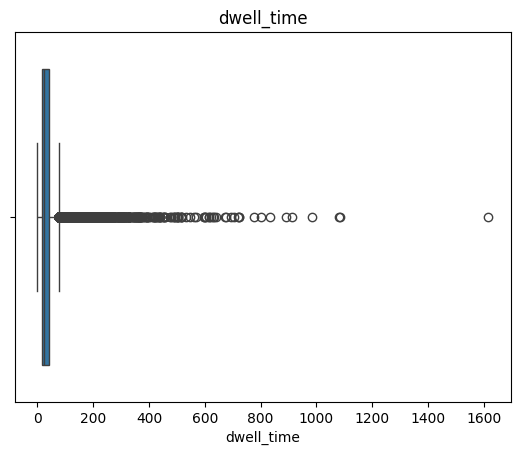

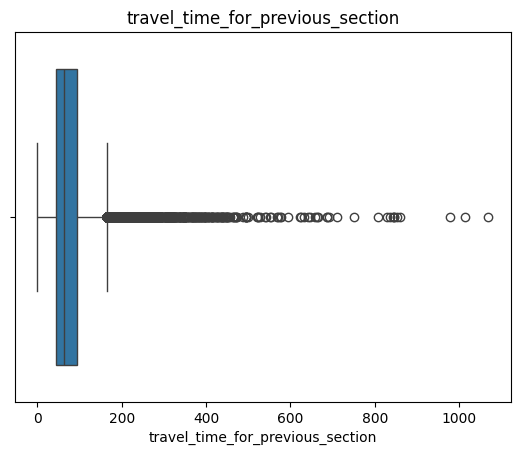

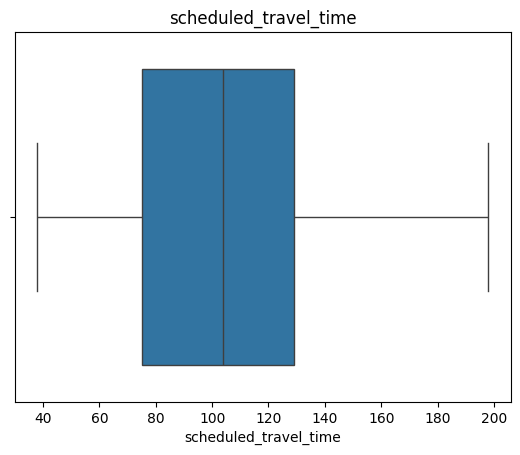

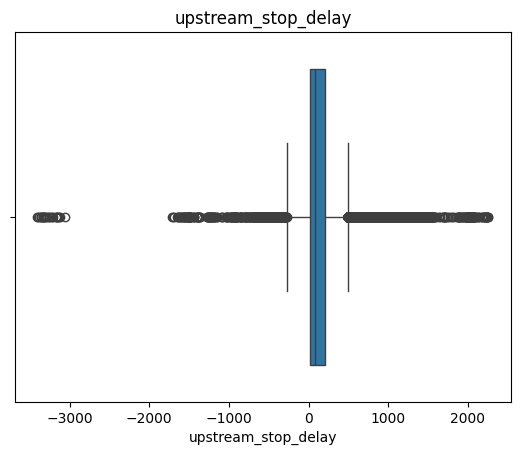

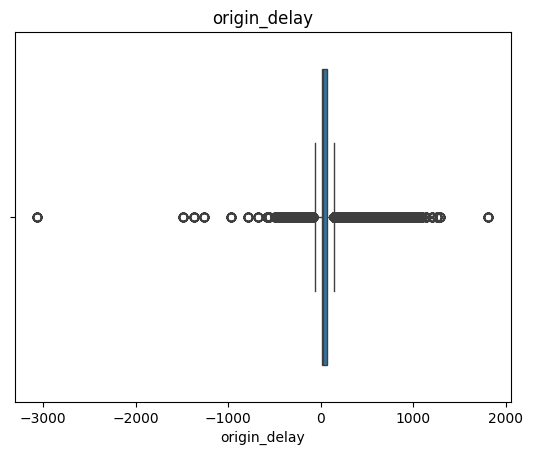

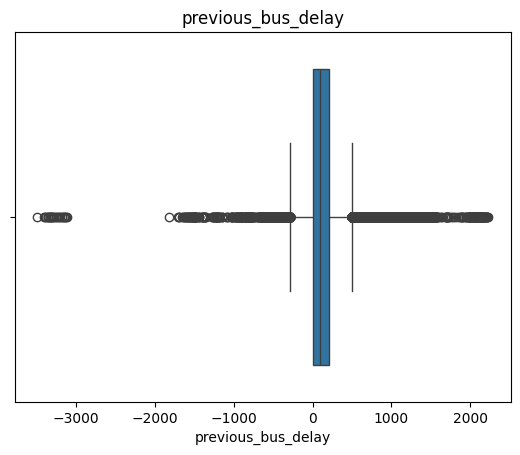

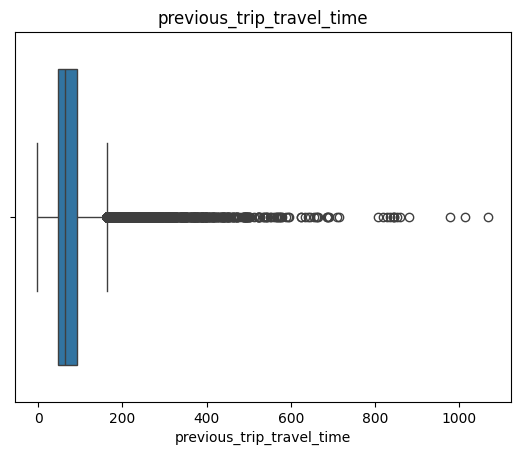

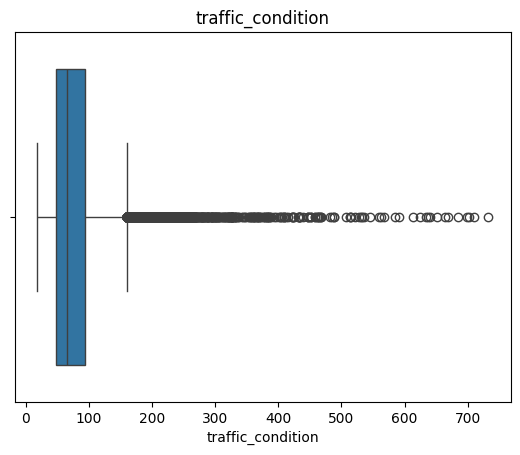

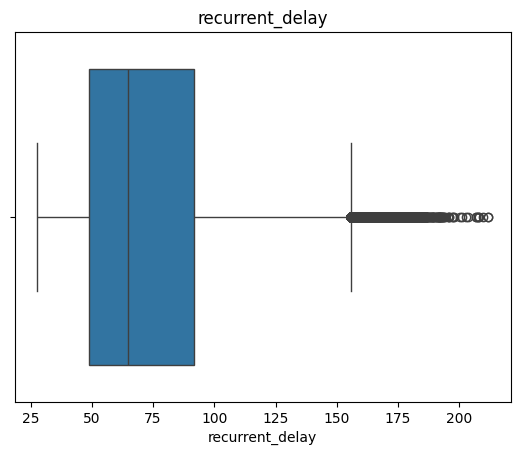

In [9]:
num_cols = [
    'arrival_delay','dwell_time','travel_time_for_previous_section',
    'scheduled_travel_time','upstream_stop_delay','origin_delay',
    'previous_bus_delay','previous_trip_travel_time',
    'traffic_condition','recurrent_delay'
]

# Histograms & boxplots
df[num_cols].hist(bins=40, figsize=(15,10))
plt.tight_layout()
plt.show()

for col in num_cols:
    sns.boxplot(x=df[col])
    plt.title(col)
    plt.show()


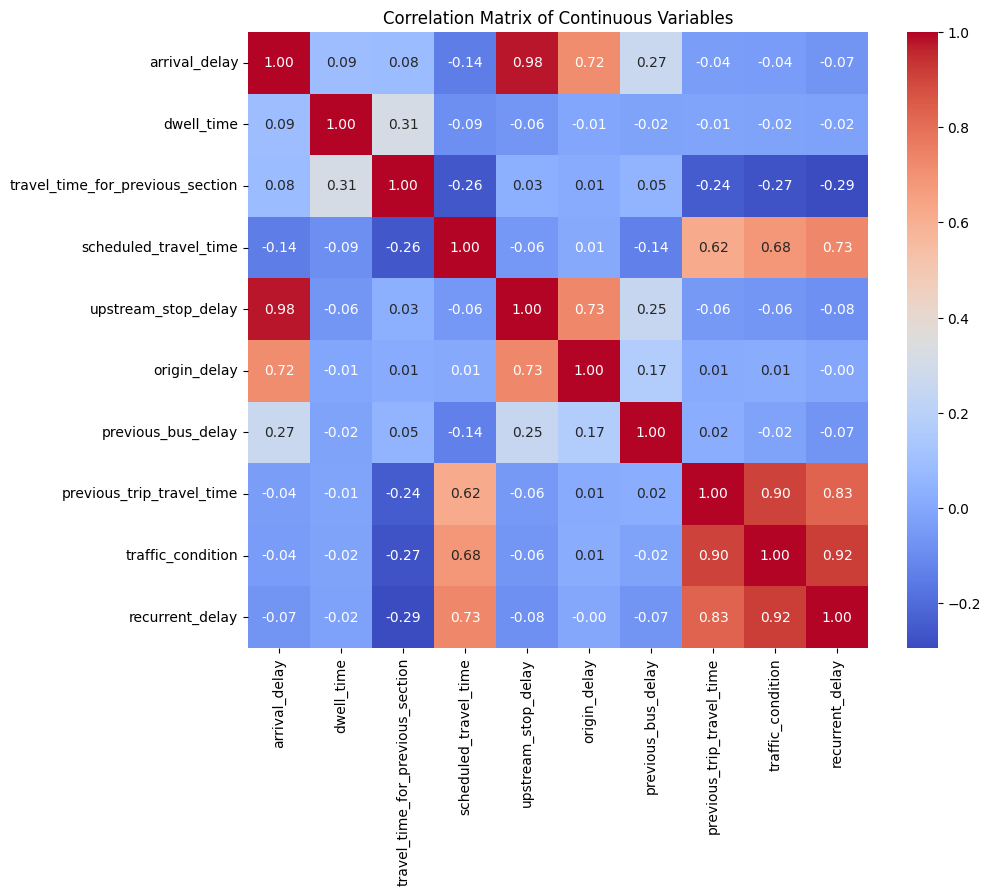

In [10]:
corr = df[num_cols].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Continuous Variables")
plt.show()


In [11]:
df.groupby('time_of_day')['arrival_delay'].describe()


,count,mean,std,min,25%,50%,75%,max
time_of_day,,,,,,,,
AP,113751.0,100.254890,186.904289,-1656.0,-12.0,54.0,166.0,1605.0
MP,89883.0,100.345238,177.431529,-3493.0,-2.0,69.0,172.0,2210.0
OP,341469.0,155.652042,197.356115,-1349.0,26.0,105.0,233.0,2257.0


In [12]:
df.groupby('weather')['arrival_delay'].mean().sort_values()


,arrival_delay
weather,
Light Rain,101.520843
Light Snow,116.779733
Snow,131.268992
Normal,136.034216
Rain,161.584593


In [13]:
df.groupby('day_of_week')['arrival_delay'].mean()


,arrival_delay
day_of_week,
weekday,114.589024
weekend,202.108527


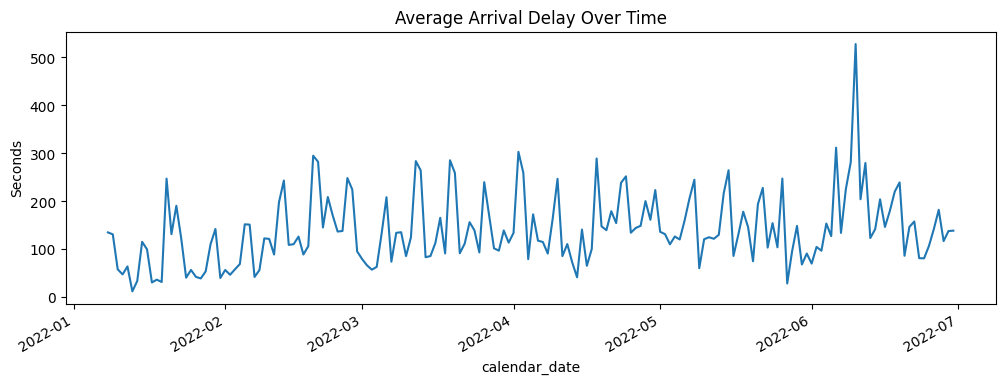

In [14]:
df['calendar_date'] = pd.to_datetime(df['calendar_date'], format='%Y%m%d')
daily_delay = df.groupby('calendar_date')['arrival_delay'].mean()
daily_delay.plot(figsize=(12,4))
plt.title("Average Arrival Delay Over Time")
plt.ylabel("Seconds")
plt.show()


In [15]:
for col in num_cols:
    q1, q3 = df[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    outliers = df[(df[col] < q1 - 1.5*iqr) | (df[col] > q3 + 1.5*iqr)]
    print(f"{col}: {len(outliers)} outliers")


arrival_delay: 28835 outliers
dwell_time: 30726 outliers
travel_time_for_previous_section: 9689 outliers
scheduled_travel_time: 0 outliers
upstream_stop_delay: 29886 outliers
origin_delay: 77571 outliers
previous_bus_delay: 29062 outliers
previous_trip_travel_time: 10476 outliers
traffic_condition: 9228 outliers
recurrent_delay: 14260 outliers


Data Preprocessing

In [16]:
# Missing values count
print(df.isna().sum())

# Example strategies
# Drop rows with too many missing values
df.dropna(thresh=len(df.columns)-3, inplace=True)  # allow ≤3 NaNs per row

# Fill numeric NaNs with median
num_cols = df.select_dtypes(include=[np.number]).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Fill categorical NaNs with mode
cat_cols = df.select_dtypes(include='object').columns
df[cat_cols] = df[cat_cols].fillna(df[cat_cols].mode().iloc[0])


calendar_date                        0
route_id                             0
bus_id                               0
stop_sequence                        0
arrival_delay                        0
dwell_time                           0
travel_time_for_previous_section     0
scheduled_travel_time                0
upstream_stop_delay                  0
origin_delay                         0
previous_bus_delay                   0
previous_trip_travel_time            0
traffic_condition                    0
recurrent_delay                      0
weather                              0
temperature                          0
day_of_week                          0
time_of_day                          0
factor(weather)Light_Rain            0
factor(weather)Light_Snow            0
factor(weather)Normal                0
factor(weather)Rain                  0
factor(weather)Snow                  0
factor(temperature)Cold              0
factor(temperature)Extra_cold        0
factor(temperature)Normal

In [17]:
df.drop_duplicates(inplace=True)
df.drop(columns=["upstream_stop_delay", "previous_bus_delay", "travel_time_for_previous_section"], inplace=True)


In [18]:
if 'calendar_date' in df.columns:
    df['calendar_date'] = pd.to_datetime(df['calendar_date'], format='%Y%m%d')


In [19]:
num_cols = [col for col in num_cols if col in df.columns]
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')


In [20]:
cat_cols = ['day_of_week', 'time_of_day', 'weather', 'temperature']
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)


In [21]:
from sklearn.preprocessing import StandardScaler

# Define numeric features to scale
num_cols = [
    'arrival_delay','dwell_time',
    'scheduled_travel_time','origin_delay',
    'traffic_condition','recurrent_delay'
]

scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])


In [22]:
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545103 entries, 0 to 545102
Data columns (total 33 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   calendar_date                      545103 non-null  datetime64[ns]
 1   route_id                           545103 non-null  int64         
 2   bus_id                             545103 non-null  int64         
 3   stop_sequence                      545103 non-null  int64         
 4   arrival_delay                      545103 non-null  float64       
 5   dwell_time                         545103 non-null  float64       
 6   scheduled_travel_time              545103 non-null  float64       
 7   origin_delay                       545103 non-null  float64       
 8   previous_trip_travel_time          545103 non-null  int64         
 9   traffic_condition                  545103 non-null  float64       
 10  recurrent_delay     

In [23]:
# Parse calendar_date (already in 'YYYY-MM-DD' format)
df["calendar_date"] = pd.to_datetime(df["calendar_date"], format="%Y-%m-%d")

# Estimate scheduled arrival time assuming service starts at 6:00 AM (21600 seconds)
df["scheduled_dt"] = df["calendar_date"] + pd.to_timedelta(21600 + df["scheduled_travel_time"], unit="s")

# Estimate actual arrival time by adding delay
df["actual_arrival_dt"] = df["scheduled_dt"] + pd.to_timedelta(df["arrival_delay"], unit="s")

# Extract calendar components
df["year"]       = df["calendar_date"].dt.year
df["month"]      = df["calendar_date"].dt.month
df["day"]        = df["calendar_date"].dt.day
df["dayofweek"]  = df["calendar_date"].dt.dayofweek  # 0 = Monday
df["is_weekend"] = df["dayofweek"].isin([5, 6]).astype(int)

# Extract hour of actual arrival
df["arrival_hour"] = df["actual_arrival_dt"].dt.hour


In [24]:
# Relative position along the 28-stop route
df['route_progress'] = df['stop_sequence'] / 28

In [25]:
# Sort by bus, date, and stop sequence to ensure chronological order
df = df.sort_values(["bus_id", "calendar_date", "stop_sequence"])

# Initialize tracking variables
trip_ids = []
trip_counter = 0
last_bus_date = (None, None)
last_stop_seq = None

# Iterate through rows to assign trip keys
for _, row in df.iterrows():
    current_key = (row["bus_id"], row["calendar_date"].date())
    stop_seq = row["stop_sequence"]

    # Detect new trip: either a new bus-date combo or a reset in stop sequence
    if current_key != last_bus_date or (last_stop_seq is not None and stop_seq <= last_stop_seq):
        trip_counter += 1

    trip_ids.append(f"{current_key[0]}_{current_key[1]}_{trip_counter}")
    last_bus_date = current_key
    last_stop_seq = stop_seq

# Assign trip_key to DataFrame
df["trip_key"] = trip_ids


Feature Engineering

In [26]:
df["hour"] = df["actual_arrival_dt"].dt.hour
df["hour_sin"] = np.sin(2*np.pi*df["hour"]/24)
df["hour_cos"] = np.cos(2*np.pi*df["hour"]/24)
# One-hot categorical features
for col in ["day_of_week", "time_of_day", "weather", "temperature"]:
    if col in df.columns:
        df = pd.concat([df, pd.get_dummies(df[col], prefix=col)], axis=1)

feature_cols = ["stop_sequence","hour_sin","hour_cos"] + \
               [c for c in df.columns if c.startswith(("day_of_week_","time_of_day_","weather_","temperature_"))] + \
               [c for c in [
    "origin_delay",
    "recurrent_delay",
    "scheduled_travel_time",
    "travel_time_for_previous_section",
    "dwell_time",
    "traffic_condition"]
                if c in df.columns]

In [27]:
# ---------- 3. Build Samples with recurrent_next_h ----------
rows, targets, masks, meta = [], [], [], []
max_len = 27   # downstream stops (28 total stops → 27 max ahead)

# Ensure recurrent_delay exists
if 'recurrent_delay' not in df.columns:
    df['recurrent_delay'] = 0.0

for trip, g in df.groupby("trip_key"):
    g = g.sort_values("stop_sequence").reset_index(drop=True)
    n = len(g)
    if n < 2:
        continue

    delays = g["arrival_delay"].values.astype(float)
    recs   = g["recurrent_delay"].values.astype(float)

    for k in range(n-1):
        cur = g.loc[k]
        feat = {}

        # ---- Base features ----
        feat["stop_sequence"] = cur["stop_sequence"]
        feat["hour_sin"] = cur["hour_sin"]
        feat["hour_cos"] = cur["hour_cos"]
        if "route_progress" in g.columns:
            feat["route_progress"] = cur["route_progress"]

        # one-hot / categorical features already expanded
        for c in [c for c in df.columns if c.startswith(("day_of_week_","time_of_day_","weather_","temperature_"))]:
            feat[c] = cur[c]

        # ITS features if available
        for c in [
            "upstream_stop_delay","origin_delay","previous_bus_delay",
            "scheduled_travel_time","travel_time_for_previous_section",
            "dwell_time","traffic_condition","previous_trip_travel_time"
        ]:
            if c in g.columns:
                feat[c] = cur[c]

        # ---- Add recurrent delay for each downstream stop ----
        downstream_recs = recs[k+1:]
        for h, val in enumerate(downstream_recs, start=1):
            feat[f"recurrent_next_{h}"] = val
        pad_len = max_len - len(downstream_recs)
        for h in range(len(downstream_recs)+1, max_len+1):
            feat[f"recurrent_next_{h}"] = 0.0

        # ---- Targets: downstream actual delays ----
        y = delays[k+1:].tolist()
        targets.append(y + [0]*pad_len)
        masks.append([1]*len(y) + [0]*pad_len)

        rows.append(feat)
        meta.append((trip, int(cur["stop_sequence"])))

# Convert to arrays
X = pd.DataFrame(rows).fillna(0)
Y = np.array(targets)
MASK = np.array(masks)


In [28]:
# ---------- 4. Temporal Split -------------
# ✅ NEW (optimized)
trip_date_map = df.groupby("trip_key")["calendar_date"].first().to_dict()
dates = [trip_date_map[m[0]] for m in meta]
dates = pd.to_datetime(dates)

train_idx = dates.month.isin([1, 2, 3, 4])
val_idx   = dates.month == 5
test_idx  = dates.month == 6


X_train, y_train, mask_train = X[train_idx], Y[train_idx], MASK[train_idx]
X_val,   y_val,   mask_val   = X[val_idx],   Y[val_idx],   MASK[val_idx]
X_test,  y_test,  mask_test  = X[test_idx],  Y[test_idx],  MASK[test_idx]

print("Train/Val/Test:", X_train.shape, X_val.shape, X_test.shape)

Train/Val/Test: (72696, 45) (18538, 45) (15704, 45)


In [29]:
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from lightgbm import LGBMRegressor

# --- Fit model ---
lgb = MultiOutputRegressor(LGBMRegressor(n_estimators=200, learning_rate=0.05))
lgb.fit(X_train, y_train)
pred_lgb = lgb.predict(X_test)

# --- Inverse transform using raw scaler ---
df_raw = pd.read_csv('Dataset-PT.csv', skiprows=1)
scaler_arrival = StandardScaler()
scaler_arrival.fit(df_raw[['arrival_delay']])
pred_lgb_inverse = scaler_arrival.inverse_transform(pred_lgb)
y_test_inverse = scaler_arrival.inverse_transform(y_test)

# --- Metric functions ---
def masked_r2(y_true, y_pred, mask):
    return [
        r2_score(y_true[mask[:, i] == 1, i], y_pred[mask[:, i] == 1, i])
        if mask[:, i].sum() > 0 else np.nan
        for i in range(y_true.shape[1])
    ]

def masked_mae(y_true, y_pred, mask):
    return [
        mean_absolute_error(y_true[mask[:, i] == 1, i], y_pred[mask[:, i] == 1, i])
        if mask[:, i].sum() > 0 else np.nan
        for i in range(y_true.shape[1])
    ]

# --- Compute metrics ---
r2_per_horizon = masked_r2(y_test_inverse, pred_lgb_inverse, mask_test)
mae_per_horizon = masked_mae(y_test_inverse, pred_lgb_inverse, mask_test)

# --- Combine and display as DataFrame ---
metrics_df = pd.DataFrame({
    'Horizon': range(1, len(r2_per_horizon) + 1),
    'MAE (sec)': mae_per_horizon,
    'R² Score': r2_per_horizon
})

print(metrics_df.head(27).to_string(index=False))


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018669 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7622
[LightGBM] [Info] Number of data points in the train set: 72696, number of used features: 44
[LightGBM] [Info] Start training from score -0.066009
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018527 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7622
[LightGBM] [Info] Number of data points in the train set: 72696, number of used features: 44
[LightGBM] [Info] Start training from score -0.017076
[LightGBM] [Warning] Found

True Delay Vector (seconds): [ 33.          29.          77.         140.         183.
 183.         159.         244.         263.         263.
 233.         248.         236.         232.         202.
 235.         299.         299.         273.         262.
 245.         218.         202.         234.         241.
 193.         134.97223827]
Predicted Delay Vector (seconds): [ 56.51289242  83.83291732  40.00817922  87.31500504 100.18465285
  88.29970691  59.00954004  96.99785458 129.64363158  84.55749885
  50.6470743  140.49394577 140.8870369  144.80085381 109.96216043
 160.37765099 192.2024344  193.31864656 149.5474934  142.68750344
 136.93213442 124.84002104  98.33137818 124.60221818 116.22153697
  13.70921526 134.97223827]
Valid Mask: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]

✅ RMSE: 111.48 seconds
✅ MAE: 104.49 seconds
✅ MAPE: 55.88%


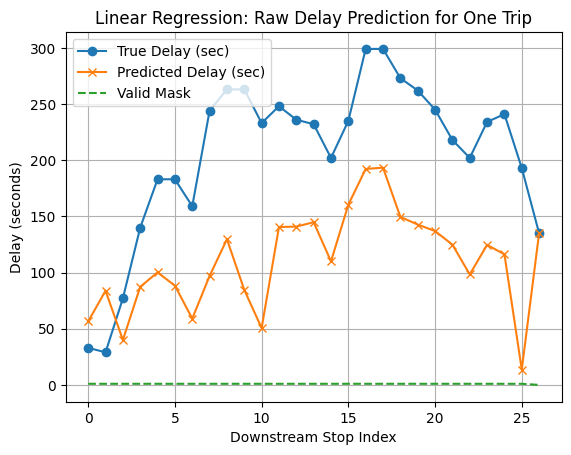

In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load original, unscaled data
df_raw = pd.read_csv('Dataset-PT.csv', skiprows=1)

# Fit scaler on raw arrival_delay values
scaler_arrival = StandardScaler()
scaler_arrival.fit(df_raw[['arrival_delay']])

# Train linear regression model
linreg = MultiOutputRegressor(LinearRegression())
linreg.fit(X_train, y_train)

# Predict on test set
pred_linreg = linreg.predict(X_test)

# Choose a sample index
i = 0

# Inverse transform predictions and ground truth
true_raw = scaler_arrival.inverse_transform(y_test[i].reshape(-1, 1)).flatten()
pred_raw = scaler_arrival.inverse_transform(pred_linreg[i].reshape(-1, 1)).flatten()
mask = mask_test[i].astype(bool)

# Filter valid entries
true_valid = true_raw[mask]
pred_valid = pred_raw[mask]

# Compute metrics
rmse = np.sqrt(mean_squared_error(true_valid, pred_valid))
mae = mean_absolute_error(true_valid, pred_valid)
mape = np.mean(np.abs((true_valid - pred_valid) / np.maximum(np.abs(true_valid), 1e-5))) * 100

# Print results
print("True Delay Vector (seconds):", true_raw)
print("Predicted Delay Vector (seconds):", pred_raw)
print("Valid Mask:", mask_test[i])
print(f"\n✅ RMSE: {rmse:.2f} seconds")
print(f"✅ MAE: {mae:.2f} seconds")
print(f"✅ MAPE: {mape:.2f}%")

# Plot
plt.plot(true_raw, label="True Delay (sec)", marker='o')
plt.plot(pred_raw, label="Predicted Delay (sec)", marker='x')
plt.plot(mask_test[i], label="Valid Mask", linestyle="--")
plt.title("Linear Regression: Raw Delay Prediction for One Trip")
plt.xlabel("Downstream Stop Index")
plt.ylabel("Delay (seconds)")
plt.legend()
plt.grid(True)
plt.show()


In [31]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from lightgbm import LGBMRegressor

# --- Fit model ---
lgb = MultiOutputRegressor(LGBMRegressor(n_estimators=200, learning_rate=0.05))
lgb.fit(X_train, y_train)
pred_lgb = lgb.predict(X_test)

# --- Inverse transform using raw scaler ---
df_raw = pd.read_csv('Dataset-PT.csv', skiprows=1)
scaler_arrival = StandardScaler()
scaler_arrival.fit(df_raw[['arrival_delay']])
pred_lgb_inverse = scaler_arrival.inverse_transform(pred_lgb)
y_test_inverse = scaler_arrival.inverse_transform(y_test)

# --- Masked Metric Functions ---
def masked_mae(y_true, y_pred, mask):
    return [
        mean_absolute_error(y_true[mask[:, i] == 1, i], y_pred[mask[:, i] == 1, i])
        if mask[:, i].sum() > 0 else np.nan
        for i in range(y_true.shape[1])
    ]

def masked_rmse(y_true, y_pred, mask):
    return [
        np.sqrt(mean_squared_error(y_true[mask[:, i] == 1, i], y_pred[mask[:, i] == 1, i]))
        if mask[:, i].sum() > 0 else np.nan
        for i in range(y_true.shape[1])
    ]

def masked_r2(y_true, y_pred, mask):
    return [
        r2_score(y_true[mask[:, i] == 1, i], y_pred[mask[:, i] == 1, i])
        if mask[:, i].sum() > 0 else np.nan
        for i in range(y_true.shape[1])
    ]

def masked_mape(y_true, y_pred, mask):
    return [
        np.mean(np.abs((y_true[mask[:, i] == 1, i] - y_pred[mask[:, i] == 1, i]) /
                       np.maximum(np.abs(y_true[mask[:, i] == 1, i]), 1e-5))) * 100
        if mask[:, i].sum() > 0 else np.nan
        for i in range(y_true.shape[1])
    ]

# --- Compute metrics ---
mae_per_horizon = masked_mae(y_test_inverse, pred_lgb_inverse, mask_test)
rmse_per_horizon = masked_rmse(y_test_inverse, pred_lgb_inverse, mask_test)
r2_per_horizon = masked_r2(y_test_inverse, pred_lgb_inverse, mask_test)
mape_per_horizon = masked_mape(y_test_inverse, pred_lgb_inverse, mask_test)

# --- Combine and display as DataFrame ---
metrics_df = pd.DataFrame({
    'Horizon': range(1, len(r2_per_horizon) + 1),
    'MAE (sec)': mae_per_horizon,
    'RMSE (sec)': rmse_per_horizon,
    'R² Score': r2_per_horizon,
    'MAPE (%)': mape_per_horizon
})

print(metrics_df.head(27).to_string(index=False))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021115 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7622
[LightGBM] [Info] Number of data points in the train set: 72696, number of used features: 44
[LightGBM] [Info] Start training from score -0.066009
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018310 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7622
[LightGBM] [Info] Number of data points in the train set: 72696, number of used features: 44
[LightGBM] [Info] Start training from score -0.017076
[LightGBM] [Warning] Found

True Delay Vector (seconds): [232.         202.         235.         299.         299.
 273.         262.         245.         218.         202.
 234.         241.         193.         134.97223827 134.97223827
 134.97223827 134.97223827 134.97223827 134.97223827 134.97223827
 134.97223827 134.97223827 134.97223827 134.97223827 134.97223827
 134.97223827 134.97223827]
Predicted Delay Vector (seconds): [115.03326197 127.05910171 165.22613603 207.443907   202.21947781
 139.98785335 161.32961893 152.58502889 160.49648813 151.18997847
 135.8336629  152.53061341  65.98763385 139.66372559 134.81850458
 134.50101548 134.20324614 135.08946322 134.95379584 134.95872265
 134.96032418 134.95900311 134.95363432 134.95666818 134.96108664
 134.97214898 134.97223827]
Valid Mask: [1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

✅ RMSE: 95.18 seconds
✅ MAE: 92.16 seconds
✅ MAPE: 38.54%
✅ R² Score: -7.2645


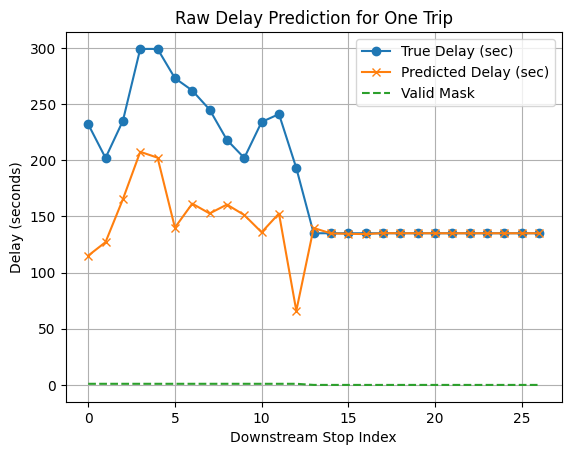

In [35]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

df_raw = pd.read_csv('Dataset-PT.csv', skiprows=1)

scaler_arrival = StandardScaler()
scaler_arrival.fit(df_raw[['arrival_delay']])  # now using truly unscaled data


i = 13  # sample index

# Inverse transform predictions and ground truth
true_raw = scaler_arrival.inverse_transform(y_test[i].reshape(-1, 1)).flatten()
pred_raw = scaler_arrival.inverse_transform(pred_lgb[i].reshape(-1, 1)).flatten()
mask = mask_test[i].astype(bool)

# Filter valid entries
true_valid = true_raw[mask]
pred_valid = pred_raw[mask]

# Compute metrics
rmse = np.sqrt(mean_squared_error(true_valid, pred_valid))
mae = mean_absolute_error(true_valid, pred_valid)
mape = np.mean(np.abs((true_valid - pred_valid) / np.maximum(np.abs(true_valid), 1e-5))) * 100
r2 = r2_score(true_valid, pred_valid)

# Print results
print("True Delay Vector (seconds):", true_raw)
print("Predicted Delay Vector (seconds):", pred_raw)
print("Valid Mask:", mask_test[i])
print(f"\n✅ RMSE: {rmse:.2f} seconds")
print(f"✅ MAE: {mae:.2f} seconds")
print(f"✅ MAPE: {mape:.2f}%")
print(f"✅ R² Score: {r2:.4f}")
# Plot
plt.plot(true_raw, label="True Delay (sec)", marker='o')
plt.plot(pred_raw, label="Predicted Delay (sec)", marker='x')
plt.plot(mask_test[i], label="Valid Mask", linestyle="--")
plt.title("Raw Delay Prediction for One Trip")
plt.xlabel("Downstream Stop Index")
plt.ylabel("Delay (seconds)")
plt.legend()
plt.grid(True)
plt.show()

In [33]:
# ---------- 7. LSTM Seq2Seq ---------------
def build_seq_data(X_df, Y_arr, mask_arr):
    Xarr = X_df.values.astype(np.float32)
    n, f = Xarr.shape
    Xseq = np.repeat(Xarr[:,None,:], max_len, axis=1)        # [n,max_len,f]
    Yseq = Y_arr[:,:max_len].reshape(n,max_len,1)
    return Xseq, Yseq, mask_arr[:,:max_len]

Xtr_s, ytr_s, mtr_s = build_seq_data(X_train, y_train, mask_train)
Xv_s,  yv_s,  mv_s  = build_seq_data(X_val,   y_val,   mask_val)
Xte_s, yte_s, mte_s = build_seq_data(X_test,  y_test,  mask_test)

model = models.Sequential([
    layers.Masking(mask_value=0., input_shape=(max_len, Xtr_s.shape[2])),
    layers.LSTM(128, return_sequences=True),
    layers.TimeDistributed(layers.Dense(1))
])
model.compile(optimizer="adam", loss="mae")
model.fit(Xtr_s, ytr_s, validation_data=(Xv_s, yv_s),
          epochs=30, batch_size=64,
          callbacks=[callbacks.EarlyStopping(patience=5, restore_best_weights=True)])

pred_seq = model.predict(Xte_s).reshape(Xte_s.shape[0], max_len)
print("LSTM MAE per horizon:", masked_mae(y_test, pred_seq, mask_test)[:10])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
1136/1136 ━━━━━━━━━━━━━━━━━━━━ 76s 63ms/step - loss: 0.0840 - val_loss: 0.0773
Epoch 2/30
1136/1136 ━━━━━━━━━━━━━━━━━━━━ 74s 65ms/step - loss: 0.0681 - val_loss: 0.0765
Epoch 3/30
1136/1136 ━━━━━━━━━━━━━━━━━━━━ 73s 64ms/step - loss: 0.0687 - val_loss: 0.0775
Epoch 4/30
1136/1136 ━━━━━━━━━━━━━━━━━━━━ 72s 63ms/step - loss: 0.0661 - val_loss: 0.0781
Epoch 5/30
1136/1136 ━━━━━━━━━━━━━━━━━━━━ 83s 64ms/step - loss: 0.0653 - val_loss: 0.0740
Epoch 6/30
1136/1136 ━━━━━━━━━━━━━━━━━━━━ 74s 65ms/step - loss: 0.0635 - val_loss: 0.0736
Epoch 7/30
 314/1136 ━━━━━━━━━━━━━━━━━━━━ 1:03 77ms/step - loss: 0.0669

KeyboardInterrupt: 

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load original, unscaled data
df_raw = pd.read_csv('Dataset-PT.csv', skiprows=1)

# Fit scaler on raw arrival_delay values
scaler_arrival = StandardScaler()
scaler_arrival.fit(df_raw[['arrival_delay']])

i = 0  # sample index

# Replace pred_lgb with your LSTM predictions
# Ensure pred_seq is shaped like (num_samples, num_horizons)
true_raw = scaler_arrival.inverse_transform(y_test[i].reshape(-1, 1)).flatten()
pred_raw = scaler_arrival.inverse_transform(pred_seq[i].reshape(-1, 1)).flatten()
mask = mask_test[i].astype(bool)

# Filter valid entries
true_valid = true_raw[mask]
pred_valid = pred_raw[mask]

# Compute metrics
rmse = np.sqrt(mean_squared_error(true_valid, pred_valid))
mae = mean_absolute_error(true_valid, pred_valid)
mape = np.mean(np.abs((true_valid - pred_valid) / np.maximum(np.abs(true_valid), 1e-5))) * 100

# Print results
print("True Delay Vector (seconds):", true_raw)
print("Predicted Delay Vector (seconds):", pred_raw)
print("Valid Mask:", mask_test[i])
print(f"\n✅ RMSE: {rmse:.2f} seconds")
print(f"✅ MAE: {mae:.2f} seconds")
print(f"✅ MAPE: {mape:.2f}%")

# Plot
plt.plot(true_raw, label="True Delay (sec)", marker='o')
plt.plot(pred_raw, label="Predicted Delay (sec)", marker='x')
plt.plot(mask_test[i], label="Valid Mask", linestyle="--")
plt.title("Raw Delay Prediction for One Trip (LSTM Seq2Seq)")
plt.xlabel("Downstream Stop Index")
plt.ylabel("Delay (seconds)")
plt.legend()
plt.grid(True)
plt.show()
